In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import dateutil
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mat
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

#Pandas commands to avoid warnings and unlock visualization of all the columns of any df
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = None

In [2]:
#Reading the csv file and presenting its columns
#I've checked its values, length and nulls before, it won't be presented here
df = pd.read_csv('data.csv')
print(df.columns)

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')


In [3]:
#As an RFM method is going to be applied, there's the need to create the F and M columns
# Recency is already in the df
# Frequency is the total number of transactions in the df
# Monetary is the total amount spent by the customer
df['frequency']=df['NumDealsPurchases']+df['NumWebPurchases']+df['NumCatalogPurchases']+df['NumStorePurchases']
df['monetary']=df['MntWines']+df['MntFruits']+df['MntMeatProducts']+df['MntFishProducts']+df['MntSweetProducts']+df['MntGoldProds']

In [4]:
#Creation of the RFM df and its description
rfm = df[['ID','Recency','frequency','monetary']]
rfm.describe()

,ID,Recency,frequency,monetary
count,2240.000000,2240.000000,2240.000000,2240.000000
mean,5592.159821,49.109375,14.862054,605.798214
std,3246.662198,28.962453,7.677173,602.249288
min,0.000000,0.000000,0.000000,5.000000
25%,2828.250000,24.000000,8.000000,68.750000
50%,5458.500000,49.000000,15.000000,396.000000
75%,8427.750000,74.000000,21.000000,1045.500000
max,11191.000000,99.000000,44.000000,2525.000000


In [5]:
#Ranking the clients according to the RFM method

def rank_r(x,p,t):
    if x <=t[p][0.25]:
        return str(1)
    elif x<=t[p][0.75]:
        return str(2)
    else:
        return str(3)
    
def rank_f(x,p,t):
    if x<= t[p][0.75]:
        return str(3)
    else:
        return str(1)
    
def rank_m(x,p,t):
    if x<= t[p][0.25]:
        return str(3)
    elif x<= t[p][0.75]:
        return str(2)
    else:
        return str(1)

#This function defines which segment the customer belongs to, according to his RFM score  
#definir_segmento stands for define_segment
def definir_segmento(rows):
    if rows['rfm_score']=='111':
        return 'best_users'
    elif rows['rfm_score']=='211':
        return 'almost_lost'
    elif rows['rfm_score']=='311':
        return 'lost_users'
    elif rows['rank_r']=='3':
        return 'cheap_lost'
    elif rows['rank_f']=='1':
        return 'loyal_users'
    elif rows['rank_m']=='1':
        return 'big_spender'
    elif rows['rank_f']=='3':
        return 'new_customer'
    else:
        return rows['rfm_score']
    
    

In [6]:
#The 25 and 75th quantiles are used to rank the RFM
#limiar stands for threshold
#limiar needs to be converted into a dictionary to be applied in the RFM
limiar = rfm.drop('ID', axis=1).quantile(q=[0.25, 0.75])
limiar = limiar.to_dict()

#applying the rank functions and score function
rfm['rank_r']=rfm['Recency'].apply(rank_r, args=('Recency', limiar))
rfm['rank_f']=rfm['frequency'].apply(rank_f, args=('frequency', limiar))
rfm['rank_m']=rfm['monetary'].apply(rank_m, args=('monetary',limiar))
rfm['rfm_score']=rfm['rank_r']+rfm['rank_f']+rfm['rank_m']

#storing in a column
rfm['segment']=rfm.apply(definir_segmento, axis=1)

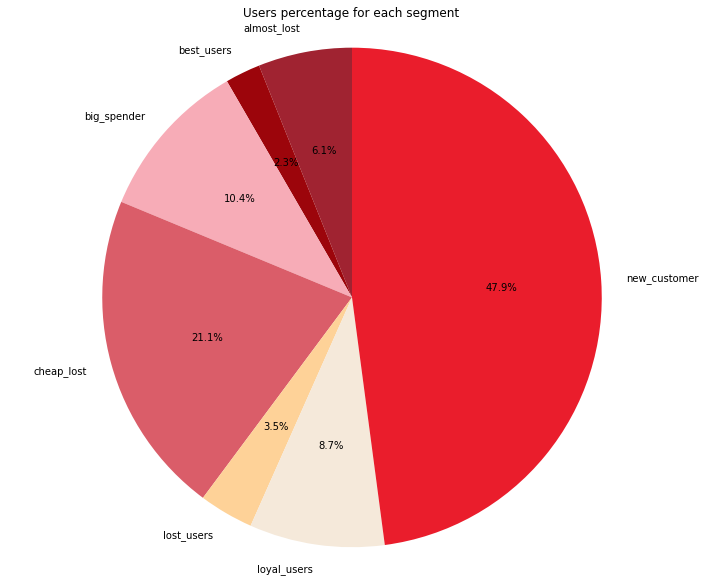

In [7]:
#creating a new array and aggregating it 
rfm_count=rfm.groupby('segment').agg({'ID':['count'], 'monetary':['sum']}).reset_index()
rfm_count.columns = ['segment', 'user', 'amount']
rfm_count[['amount']]=rfm_count[['amount']]/100

#plot
fig1, ax1 = plt.subplots(figsize=(10,8))
ax1.pie(data=rfm_count,x='user', labels='segment', autopct='%1.1f%%',
        startangle=90, colors=['#a02331','#9C050B','#F7ACB7','#DA5D69','#FED298','#F5E9DA','#EA1D2C'])

ax1.axis('equal')
plt.tight_layout()
plt.title('Users percentage for each segment')
plt.show()

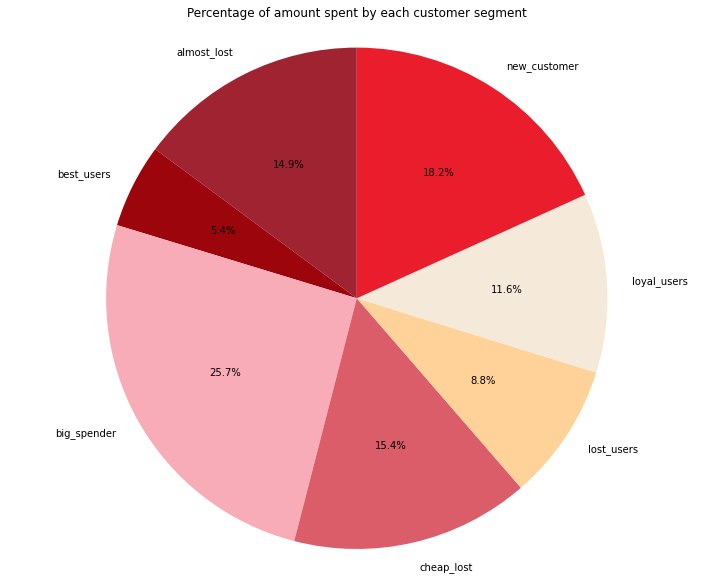

In [8]:
#plotting the percentage of spent amount per customer segment
fig1,ax1=plt.subplots(figsize=(10,8))
ax1.pie(data=rfm_count,x='amount', labels='segment', autopct='%1.1f%%', startangle=90,
       colors=['#a02331','#9C050B','#F7ACB7','#DA5D69','#FED298','#F5E9DA','#EA1D2C'])

ax1.axis('equal')

plt.tight_layout()
plt.title('Percentage of amount spent by each customer segment')
plt.show()

In [9]:
#the RFM method define that the high growth customers are
#best users, as they buy recently, frequently and spend lots of money
#and big spenders, as they buy not so frequently but the monetary
#value of each transaction is higher

#creating a function to create a column of high growth users:

def categorizacao(rows):
    if rows['segment'] =='best_users':
        return 1
    elif rows['segment']=='big_spender':
        return 1
    else:
        return 0
    
rfm['high_growth']=rfm.apply(categorizacao, axis=1)
categoria = rfm[['ID','high_growth']]

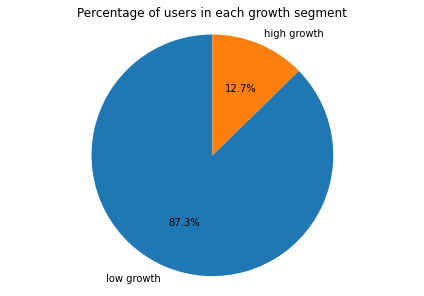

In [10]:
#analyzing the new column to see the percentage of users
#divided by the growth categorization

growth_count=rfm.groupby('high_growth').agg({'ID':['count'],'monetary':['sum']}).reset_index()
growth_count.columns=['segment','user','amount']
growth_count.loc[growth_count['segment']==0, 'segment']='low growth'
growth_count.loc[growth_count['segment']==1, 'segment']='high growth'

fig1, ax1 = plt.subplots()
ax1.pie(data=growth_count, x='user', labels='segment', autopct='%1.1f%%',
        startangle=90)
ax1.axis('equal')
plt.tight_layout()
plt.title('Percentage of users in each growth segment')
plt.show()

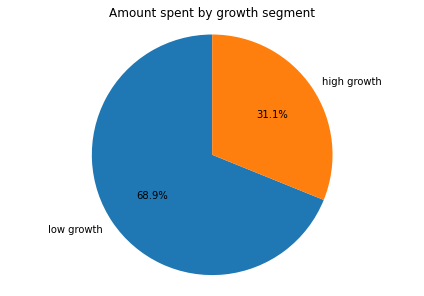

In [11]:
#also plotting their spent amount

fig1, ax1= plt.subplots()
ax1.pie(data=growth_count, x='amount', labels='segment', autopct='%1.1f%%',
        startangle=90)

ax1.axis('equal')
plt.tight_layout()
plt.title('Amount spent by growth segment')
plt.show()

In [12]:
#creating new columns in the initial df that may be useful for predictions
today=datetime.now()
df['Dt_Customer']=pd.to_datetime(df['Dt_Customer'], format='%Y-%m-%d')
df['year']=df['Dt_Customer'].apply(lambda x: x.year)
df['tenure']=df['Dt_Customer'].apply(lambda x: (today-x).days)

In [13]:
#creating a new df to use for training prediction

training_dataset=df[['ID','tenure','Recency','monetary','frequency','MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Kidhome','Teenhome', 'Income']]
training_dataset=training_dataset.merge(categoria)

#identifying columns with NA values and filling with the mean values
na_cols = training_dataset.isna().any()
na_cols = na_cols[na_cols == True].reset_index()
na_cols = na_cols['index'].tolist()

for col in training_dataset.columns[1:]:
    if col in na_cols:
        if training_dataset[col].dtype != 'object':
            training_dataset[col] = training_dataset[col].fillna(training_dataset[col].mean()).round(0)

In [14]:
#Function to print the results of the prediction test
def print_result(y_test,y_pred):
    target_names=['Low Growth','High Growth']
    print(metrics.classification_report(y_test, y_pred, target_names=target_names))
    print('Confusion Matrix: \n', metrics.confusion_matrix(y_test,y_pred))

#Using logistic regression
#Splitting the data into a (30-70) ratio for testing and training
X = training_dataset.drop(columns=['ID','high_growth'])
X = preprocessing.scale(X)
y = training_dataset['high_growth']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

#Preparing the presentation of the solver
print("\n\nLogistic Regression...")
log = linear_model.LogisticRegression(solver = 'liblinear')
log.fit(X_train, y_train)

print("\n\nTraining")
y_pred = log.predict(X_train)
print_result(y_train, y_pred)

print("\n\nTesting")
#now predict on test data
y_pred = log.predict(X_test)
print_result(y_test, y_pred)

#There's a decent performance predicting Low Growth customer
#however this code aims to the High Growth ones



Logistic Regression...


Training
              precision    recall  f1-score   support

  Low Growth       0.95      0.97      0.96      1368
 High Growth       0.77      0.65      0.70       200

    accuracy                           0.93      1568
   macro avg       0.86      0.81      0.83      1568
weighted avg       0.93      0.93      0.93      1568

Confusion Matrix: 
 [[1330   38]
 [  71  129]]


Testing
              precision    recall  f1-score   support

  Low Growth       0.95      0.98      0.97       588
 High Growth       0.85      0.63      0.73        84

    accuracy                           0.94       672
   macro avg       0.90      0.81      0.85       672
weighted avg       0.94      0.94      0.94       672

Confusion Matrix: 
 [[579   9]
 [ 31  53]]


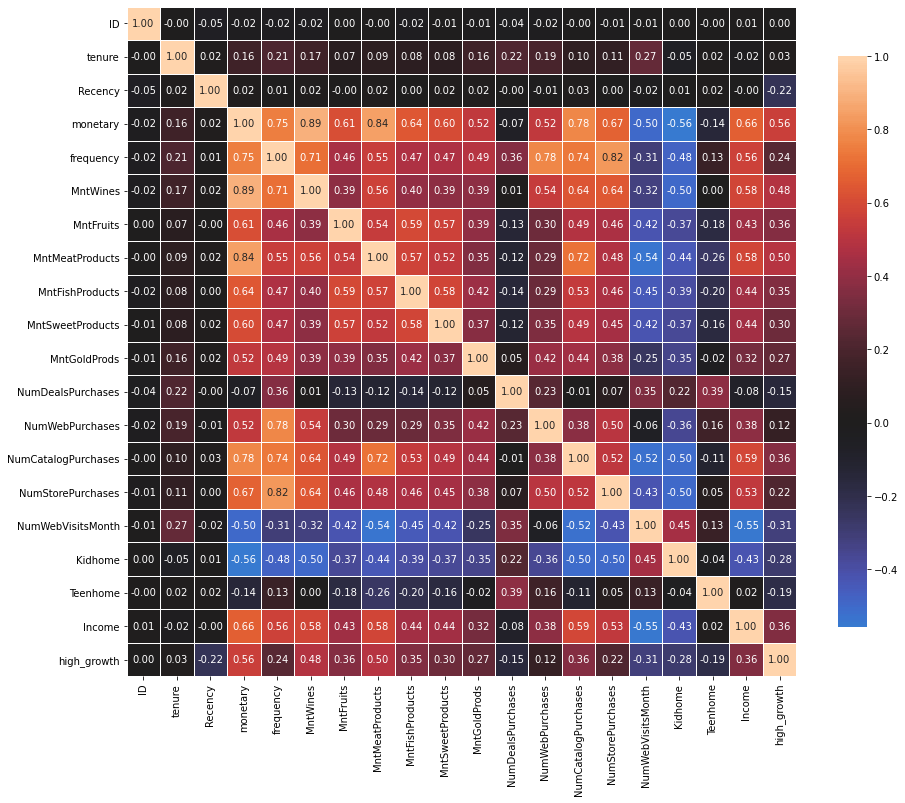

In [15]:
#Taking a look at the data correlation to understand the relationship
#between the variables of the dataset

def correlation_heatmap(training_dataset):
    correlations = training_dataset.corr()
    fig, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();

correlation_heatmap(training_dataset)

In [16]:
#Using cross-validation as an alternative
#default is 10-fold

X = training_dataset.drop(columns =['ID','high_growth'])
X = preprocessing.scale(X)
y = training_dataset['high_growth']


log = linear_model.LogisticRegression(solver = 'liblinear')
y_pred = cross_val_predict(log, X, y)
print("\n\nLogistic Regression...\n\n")
print_result(y,y_pred)

#The results were even worse



Logistic Regression...


              precision    recall  f1-score   support

  Low Growth       0.95      0.97      0.96      1956
 High Growth       0.76      0.65      0.70       284

    accuracy                           0.93      2240
   macro avg       0.85      0.81      0.83      2240
weighted avg       0.93      0.93      0.93      2240

Confusion Matrix: 
 [[1896   60]
 [  99  185]]


In [17]:
#As there's a big imbalance nature of the data, in high/low growth
#customer ratio, there's the possibility of oversampling the
#minority class until the ratio is balanced
#SMOTE may be used to avoid random oversampling and overfitting

sm = SMOTE(random_state=50)

X = training_dataset.drop(columns=['ID','high_growth'])
y = training_dataset['high_growth']

X = preprocessing.scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50) 
#once again, 70% training and 30% testing

#oversampling the training dataset
x_train_res, y_train_res = sm.fit_resample(X_train, y_train)
x_test_res, y_test_res = sm.fit_resample(X_test, y_test)
print (y_train.value_counts())
print("New Data", np.bincount(y_train_res))

print("\n\nLogistic Regression...")
log = linear_model.LogisticRegression(solver='liblinear')
log.fit(x_train_res, y_train_res)

#presenting the training results
print("\n\nTraining")
y_pred = log.predict(x_train_res)
print_result(y_train_res, y_pred)
#predicting on test data
print("\n\nTesting")
y_pred = log.predict(X_test)
print_result(y_test, y_pred)

#there was an overall progress with this method

0    1386
1     182
Name: high_growth, dtype: int64
New Data [1386 1386]


Logistic Regression...


Training
              precision    recall  f1-score   support

  Low Growth       0.96      0.90      0.93      1386
 High Growth       0.91      0.96      0.93      1386

    accuracy                           0.93      2772
   macro avg       0.93      0.93      0.93      2772
weighted avg       0.93      0.93      0.93      2772

Confusion Matrix: 
 [[1250  136]
 [  52 1334]]


Testing
              precision    recall  f1-score   support

  Low Growth       0.99      0.89      0.94       570
 High Growth       0.62      0.95      0.75       102

    accuracy                           0.90       672
   macro avg       0.80      0.92      0.84       672
weighted avg       0.93      0.90      0.91       672

Confusion Matrix: 
 [[510  60]
 [  5  97]]


In [18]:
#lastly, let's try Decision Tree method and Random Forest

X = training_dataset.drop(columns=['ID','high_growth'])
y = training_dataset['high_growth']

decision_tree_classifier = DecisionTreeClassifier()
y_pred_dt = cross_val_predict(decision_tree_classifier, X, y)
print("\n\nDecision Tree...")
print_result(y,y_pred_dt)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    
random_forest_classifier = RandomForestClassifier(n_estimators=10, criterion="entropy")
y_pred_rf = cross_val_predict(random_forest_classifier, X, y)
print("\n\nRandom Forest...")
print_result(y, y_pred_rf)    

#As it may be seen, 100% of success on prediction may be overfitted
#or have any other kind of problem. However, 99% of precision is 
#acceptable and very good. Random forest prediction will be the
#chosen method



Decision Tree...
              precision    recall  f1-score   support

  Low Growth       1.00      1.00      1.00      1956
 High Growth       1.00      1.00      1.00       284

    accuracy                           1.00      2240
   macro avg       1.00      1.00      1.00      2240
weighted avg       1.00      1.00      1.00      2240

Confusion Matrix: 
 [[1956    0]
 [   1  283]]
Accuracy: 0.9032738095238095


Random Forest...
              precision    recall  f1-score   support

  Low Growth       0.99      1.00      0.99      1956
 High Growth       0.99      0.94      0.96       284

    accuracy                           0.99      2240
   macro avg       0.99      0.97      0.98      2240
weighted avg       0.99      0.99      0.99      2240

Confusion Matrix: 
 [[1953    3]
 [  18  266]]


In [19]:
#saving the High Growth predicted customers in a csv file
training_dataset['predicted']=y_pred_rf
high_growth_customers = training_dataset.loc[training_dataset['predicted']==True]

high_growth_customers.sort_values('monetary',ascending=False).to_csv('high_growth_customer.csv',index=False)

#print('High Growth Customer: \n',high_growth_customers.sort_values('monetary', ascending=False))

In [20]:
#creating the final set of information to be analyzed
base_final = pd.merge(
    left=high_growth_customers['ID'],
    right=df,
    left_on='ID',
    right_on='ID',
    how='left')

base_final.sort_values('monetary', ascending=False)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,frequency,monetary,year,tenure
156,5735,1991,Master,Single,90638.0,0,0,2014-02-13,29,1156,120,915,94,144,96,1,3,4,10,1,0,0,1,0,0,0,3,11,0,18,2525,2014,2963
196,5350,1991,Master,Single,90638.0,0,0,2014-02-13,29,1156,120,915,94,144,96,1,3,4,10,1,0,0,1,0,0,0,3,11,1,18,2525,2014,2963
183,10133,1970,Graduation,Single,93790.0,0,0,2014-02-12,16,1302,68,731,89,114,45,0,6,7,12,2,0,1,1,1,0,0,3,11,1,25,2349,2014,2964
125,5386,1953,Graduation,Together,94384.0,0,0,2013-03-04,62,1111,24,790,160,45,172,0,5,8,5,2,0,1,1,1,0,0,3,11,1,18,2302,2013,3309
167,6024,1953,Graduation,Together,94384.0,0,0,2013-03-04,62,1111,24,790,160,45,172,0,5,8,5,2,0,1,1,1,0,0,3,11,1,18,2302,2013,3309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,5332,1960,2n Cycle,Married,82504.0,0,0,2013-07-27,2,362,50,431,134,35,54,1,3,6,7,1,0,0,0,0,0,0,3,11,0,17,1066,2013,3164
70,6931,1967,Graduation,Divorced,76982.0,0,0,2014-02-15,19,464,151,292,65,60,30,1,8,3,4,4,0,0,1,0,0,0,3,11,1,16,1062,2014,2961
110,1031,1989,2n Cycle,Married,85710.0,0,0,2013-05-05,5,600,20,350,29,30,33,1,6,9,10,2,0,0,1,0,0,0,3,11,0,26,1062,2013,3247
18,11084,1976,Master,Together,65104.0,0,1,2013-11-14,4,738,0,232,13,20,50,2,3,5,7,7,0,0,0,0,0,0,3,11,1,17,1053,2013,3054


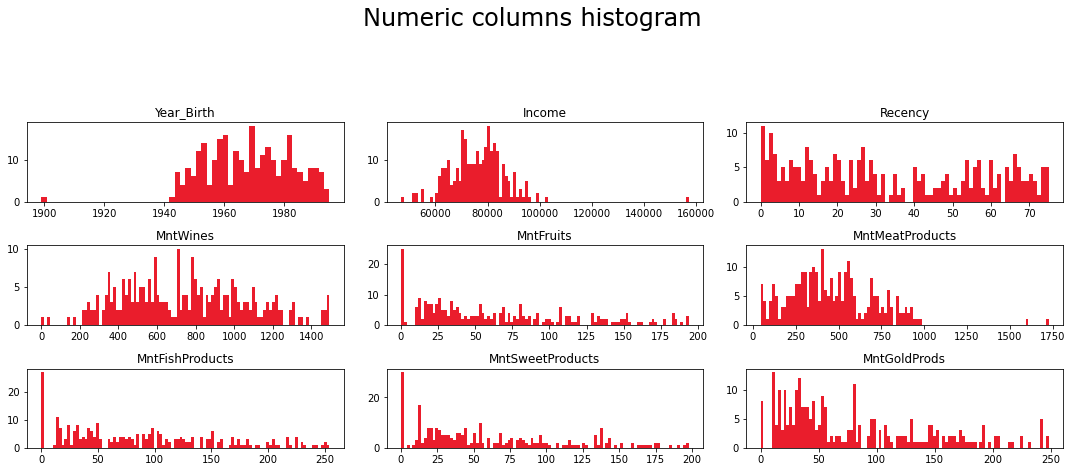

In [21]:
#plotting some histograms to check if there's any kind of standard information
# about these customers
base_final2 = base_final[['Year_Birth','Income','Recency', 'MntWines',
                'MntFruits','MntMeatProducts','MntFishProducts',
                'MntSweetProducts','MntGoldProds']]

fig = plt.figure(figsize=(15,12))
plt.suptitle('Numeric columns histogram \n', horizontalalignment='center',
             fontstyle='normal', fontsize=24, fontfamily = 'verdana')

for i in range(base_final2.shape[1]):
    plt.subplot(6,3,i+1)
    f=plt.gca()
    f.set_title(base_final2.columns.values[i])
    
    vals = np.size(base_final2.iloc[:,i].unique())
    if vals >=100:
        vals=100
    
    plt.hist(base_final2.iloc[:,i], bins=vals, color ='#ea1d2c')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [22]:
base_final.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,frequency,monetary,year,tenure
count,269.000000,269.000000,268.000000,269.00000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.000000,269.0,269.0,269.0,269.000000,269.000000,269.000000,269.000000,269.000000
mean,5616.598513,1968.167286,76275.936567,0.04461,0.219331,33.096654,746.189591,63.665428,461.245353,87.557621,59.810409,79.412639,1.438662,4.940520,5.379182,7.568773,3.245353,0.066914,0.208178,0.304833,0.197026,0.055762,0.0,3.0,11.0,0.368030,19.327138,1497.881041,2013.014870,3188.304833
std,3324.571175,14.154989,10732.771347,0.20683,0.423469,23.594324,322.382764,52.045613,250.505577,67.679236,50.771192,63.417981,1.293263,2.251905,2.526962,2.553880,2.224194,0.250340,0.406762,0.461195,0.398494,0.229889,0.0,0.0,0.0,0.483168,3.938526,328.686555,0.722611,209.296378
min,0.000000,1899.000000,46757.000000,0.00000,0.000000,0.000000,1.000000,0.000000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,3.0,11.0,0.000000,1.000000,1053.000000,2012.000000,2830.000000
25%,2611.000000,1958.000000,70038.000000,0.00000,0.000000,12.000000,483.000000,22.000000,287.000000,32.000000,20.000000,31.000000,1.000000,3.000000,4.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,3.0,11.0,0.000000,17.000000,1215.000000,2012.000000,2994.000000
50%,5350.000000,1969.000000,76428.500000,0.00000,0.000000,28.000000,738.000000,51.000000,426.000000,77.000000,45.000000,54.000000,1.000000,4.000000,5.000000,7.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,3.0,11.0,0.000000,19.000000,1428.000000,2013.000000,3217.000000
75%,8707.000000,1979.000000,82444.500000,0.00000,0.000000,56.000000,992.000000,96.000000,591.000000,133.000000,91.000000,122.000000,1.000000,6.000000,6.000000,10.000000,5.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,3.0,11.0,1.000000,21.000000,1730.000000,2014.000000,3381.000000
max,11084.000000,1995.000000,157146.000000,1.00000,2.000000,75.000000,1493.000000,194.000000,1725.000000,254.000000,198.000000,248.000000,11.000000,11.000000,28.000000,13.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,3.0,11.0,1.000000,35.000000,2525.000000,2014.000000,3524.000000


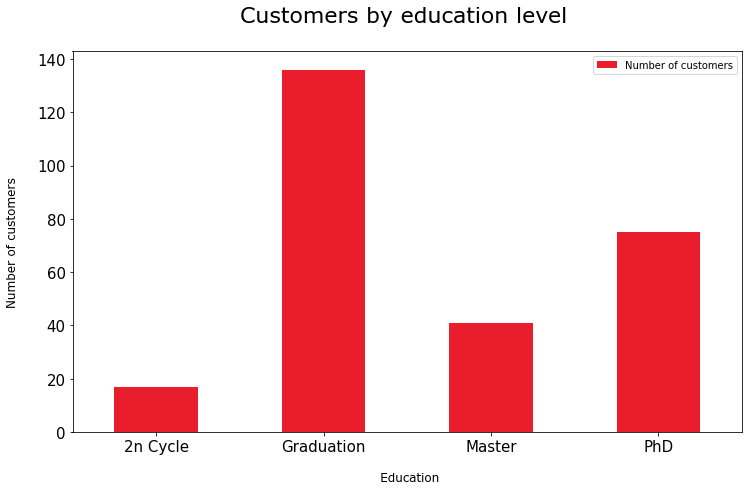

In [23]:
#presenting these customers splitted by education level
#there's a pattern here, most part of them are graduated or have higher education
education_split=base_final[['ID','Education']]
sectors = education_split.groupby('Education')
education_split = pd.DataFrame(sectors['ID'].count())
education_split.rename(columns={'ID':'Number of customers'},inplace=True)
                      
ax = education_split[['Number of customers']].plot.bar(title='Clientes segmentados pelo nivel de educação', 
                                                      legend=True, table=False,
                                                      grid=False, subplots=False, 
                                                      figsize=(12,7), color='#EA1D2C',
                                                      fontsize = 15, stacked=False)

plt.ylabel('Number of customers\n', horizontalalignment='center', fontstyle='normal',
           fontsize='large', fontfamily='verdana')

plt.xlabel('\n Education',horizontalalignment='center',fontstyle='normal',
           fontsize='large',fontfamily='verdana')

plt.title('Customers by education level \n', horizontalalignment='center',fontstyle='normal',
          fontsize='22',fontfamily='verdana')

plt.legend(loc='upper right', fontsize='medium')
plt.xticks(rotation=0, horizontalalignment='center')
plt.yticks(rotation=0, horizontalalignment='right')

x_labels=np.array(education_split[['Number of customers']])

def add_value_labels(ax,spacing=5):
    for rect in ax.patches:
        y_value=rect.get_height()
        x_value= rect.get_x() + rect.get_width()/2
        space=spacing
        va='bottom'
        
        if y_value < 0:
            space *= -1
            va = 'top'
        label = '{:.0f}'.format(y.value)
        
plt.savefig('EducationLevel')

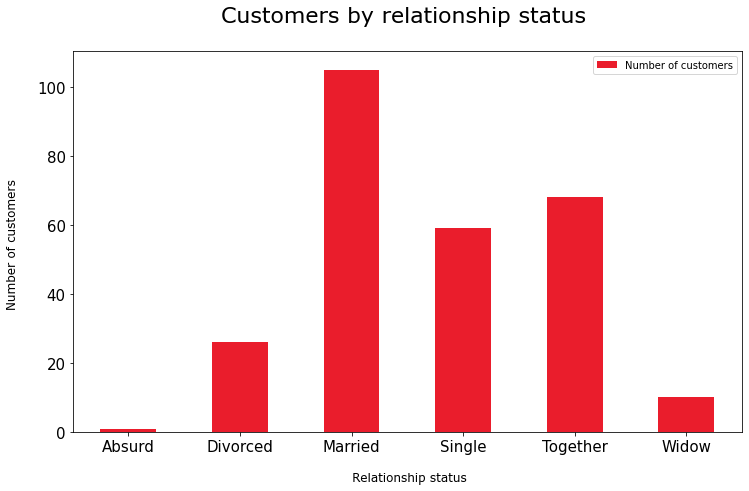

In [24]:
#splitting them by their relationship status
#there's also a pattern here, most of the customers have a partner
relationship_split=base_final[['ID','Marital_Status']]
sectors2 = relationship_split.groupby('Marital_Status')
relationship_split = pd.DataFrame(sectors2['ID'].count())
relationship_split.rename(columns={'ID':'Number of customers'},inplace=True)
                      
ax2 = relationship_split[['Number of customers']].plot.bar(title='Clientes segmentados pelo estado de relacionamento', 
                                                      legend=True, table=False,
                                                      grid=False, subplots=False, 
                                                      figsize=(12,7), color='#EA1D2C',
                                                      fontsize = 15, stacked=False)

plt.ylabel('Number of customers \n', horizontalalignment='center', fontstyle='normal',
           fontsize='large', fontfamily='verdana')

plt.xlabel('\n Relationship status',horizontalalignment='center',fontstyle='normal',
           fontsize='large',fontfamily='verdana')

plt.title('Customers by relationship status \n', horizontalalignment='center',fontstyle='normal',
          fontsize='22',fontfamily='verdana')

plt.legend(loc='upper right', fontsize='medium')
plt.xticks(rotation=0, horizontalalignment='center')
plt.yticks(rotation=0, horizontalalignment='right')

x_labels2=np.array(relationship_split[['Number of customers']])

def add_value_labels2(ax2,spacing=5):
    for rect in ax2.patches:
        y_value=rect.get_height()
        x_value= rect.get_x() + rect.get_width()/2
        space=spacing
        va='bottom'
        
        if y_value < 0:
            space *= -1
            va = 'top'
        label = '{:.0f}'.format(y.value)
        
plt.savefig('RelationshipStatus')

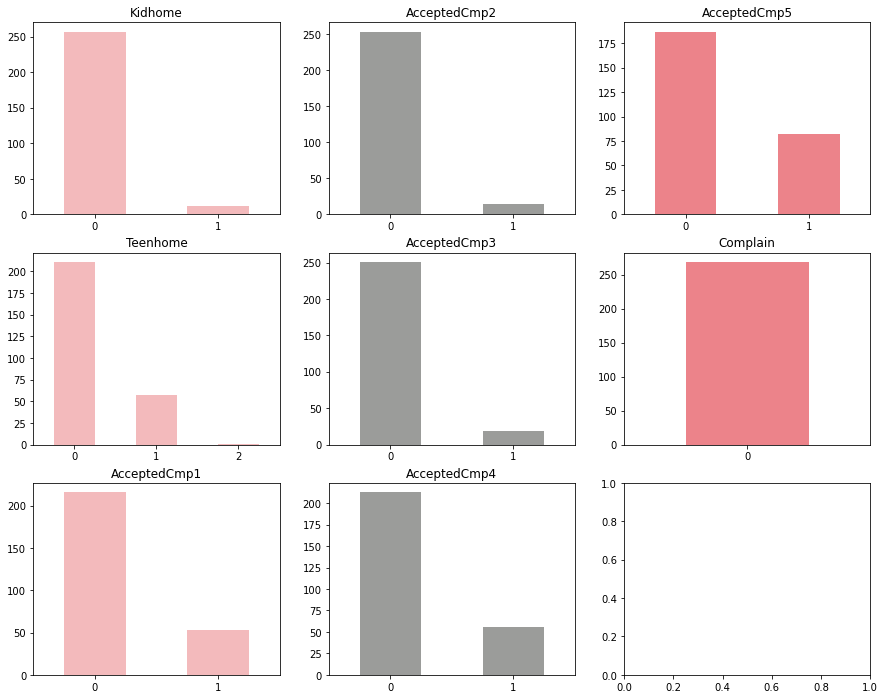

In [25]:
#Taking a look at the rest of the columns

#A good part of them Accepted Campaign 5 and Campaing 1 and 4
#Most part of them don't have Children
#Neither of these customers complained

binaries = ['Kidhome', 'Teenhome','AcceptedCmp1','AcceptedCmp2',
            'AcceptedCmp3','AcceptedCmp4','AcceptedCmp5',
            'Complain']

fig3, axes = plt.subplots(nrows=3, ncols=3,figsize=(15,12))

for i, item in enumerate(binaries):
    
    if i<3:
        ax=base_final[item].value_counts().plot(
            kind='bar',ax=axes[i,0],
            rot=0,color='#f3babc')
        ax.set_title(item)
            
    elif i>=3 and i<6:
            ax=base_final[item].value_counts().plot(
                kind='bar',ax=axes[i-3,1],
                rot=0, color='#9b9c9a')
            ax.set_title(item)
            
    elif i<9:
            ax=base_final[item].value_counts().plot(
                kind='bar',ax=axes[i-6,2],rot=0,
                color='#ec838a')
            ax.set_title(item)

<AxesSubplot:>

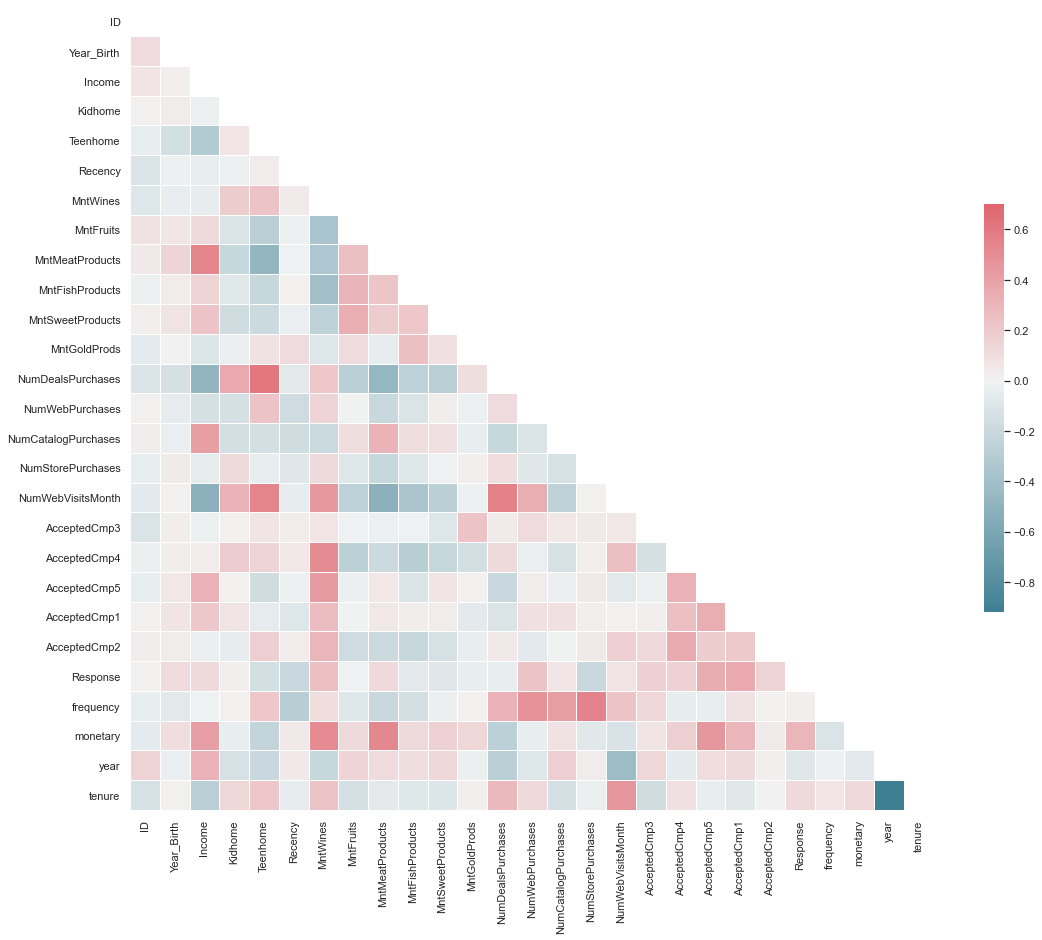

In [26]:
#Setting a heatmap of the correlations between the main aspects of these customers
sns.set(style='white')
corr=base_final.drop(columns=['Complain','Z_CostContact','Z_Revenue']).corr()

mascara = np.zeros_like(corr, dtype=bool)
mascara[np.triu_indices_from(mascara)]=True

f, ax =plt.subplots(figsize=(18,15))
cmap = sns.diverging_palette(220,10, as_cmap=True)

sns.heatmap(corr, mask=mascara, cmap=cmap, vmax=.7, center=0,
           square=True, linewidth=.5, cbar_kws={'shrink':.5})

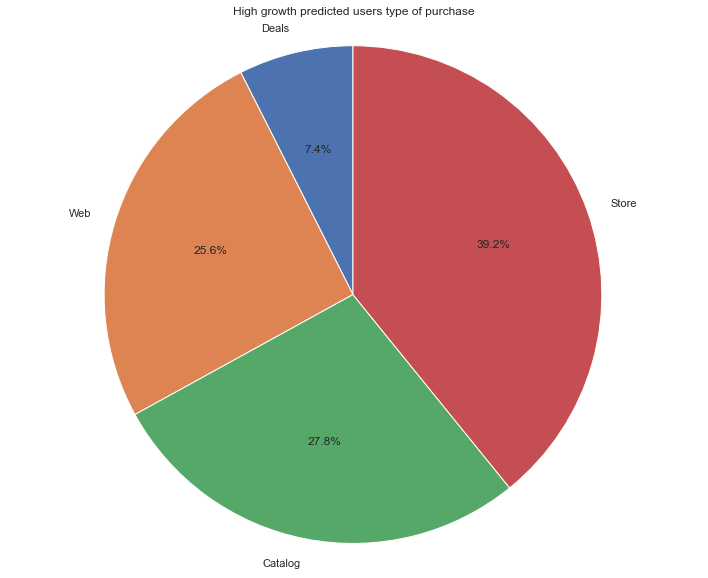

In [27]:
#Creating a simple array to plot the percentages of their purchases type

#It's possible to see that most of them buy on Stores or Catalog

TotalDealsPurchases=base_final['NumDealsPurchases'].sum()
TotalWebPurchases=base_final['NumWebPurchases'].sum()
TotalCatalogPurchases=base_final['NumCatalogPurchases'].sum()
TotalStorePurchases=base_final['NumStorePurchases'].sum()

TotalPurchases=TotalDealsPurchases+TotalWebPurchases+TotalCatalogPurchases+TotalStorePurchases

pctDeals=TotalDealsPurchases/TotalPurchases
pctWeb=TotalWebPurchases/TotalPurchases
pctCatalog=TotalCatalogPurchases/TotalPurchases
pctStore=TotalStorePurchases/TotalPurchases

ComportamentoCompras = [pctDeals,pctWeb,pctCatalog,pctStore]
ComportamentoCompras = pd.to_numeric(ComportamentoCompras,errors='coerce')
ComportamentoCompras = ComportamentoCompras.astype('float')

fig, ax = plt.subplots(figsize=(10,8))
pieLabels=['Deals','Web','Catalog','Store']
ax.pie(ComportamentoCompras, labels=pieLabels, autopct='%1.1f%%',
         startangle=90)

ax.axis('equal')
plt.tight_layout()
plt.title('High growth predicted users type of purchase')
plt.show()

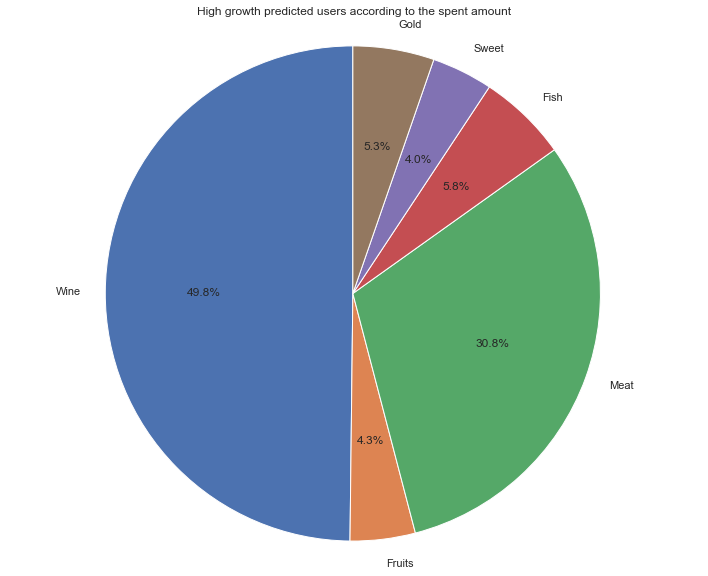

In [28]:
#Creating a simple array to understand their amount of spent money

#Most of the amount spent was on Wines and another great part on Meat

TotalWine=base_final['MntWines'].sum()
TotalFruits=base_final['MntFruits'].sum()
TotalMeat=base_final['MntMeatProducts'].sum()
TotalFish=base_final['MntFishProducts'].sum()
TotalSweet=base_final['MntSweetProducts'].sum()
TotalGold=base_final['MntGoldProds'].sum()


TotalAmount=TotalWine+TotalFruits+TotalMeat+TotalFish+TotalSweet+TotalGold

pctWine=TotalWine/TotalAmount
pctFruits=TotalFruits/TotalAmount
pctMeat=TotalMeat/TotalAmount
pctFish=TotalFish/TotalAmount
pctSweet=TotalSweet/TotalAmount
pctGold=TotalGold/TotalAmount


ValorCompras = [pctWine,pctFruits,pctMeat,pctFish,pctSweet,pctGold]
ValorCompras = pd.to_numeric(ValorCompras,errors='coerce')
ValorCompras = ValorCompras.astype('float')

fig, ax = plt.subplots(figsize=(10,8))
pieLabels=['Wine','Fruits','Meat','Fish','Sweet','Gold']
ax.pie(ValorCompras, labels=pieLabels, autopct='%1.1f%%',
         startangle=90)

ax.axis('equal')
plt.tight_layout()
plt.title('High growth predicted users according to the spent amount')
plt.show()
